# Compare Symphony to automatic cell type classifiers
July 5, 2021

In this analysis, we will run Symphony with 2 different gene selection procedures: (1) variable genes (top 2,000) and (2) marker genes selected using differential expression analysis via Presto.

For the dataset, we will use the PbmcBench benchmark from Abdelaal et al. 2019: https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1795-z

In [1]:
suppressPackageStartupMessages({
    library(harmony)
    library(symphony)
    library(presto)
    library(tidyverse)
    library(data.table)
    library(matrixStats)
    library(patchwork)
    library(ggthemes)
    library(Matrix)
    library(ggplot2)
    library(plyr)
    library(dplyr)
    library(singlecellmethods)
    library(Rcpp)
    library(class) # for knn1
    library(RANN) # for nn
    library(reshape2)
    library(ggrastr)
    library(ggpubr)
    library(readr)
    library(stringr)
    
    ## For additional models
    library(glmnet)
    library(e1071)
})

fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width)
}

Useful functions

In [2]:
# Function that builds the bsub command as a string
bsub_symphony = function(script_use, queue = 'short', email = FALSE, analysis = NULL, rexp = NULL, rlabels = NULL,
                          qexp = NULL, qlabels = NULL, save_use, submit = FALSE){
    str = paste('bsub -q', 
                queue, 
                'Rscript', script_use, 
                '--analysis', analysis, 
                '--rexp', rexp, 
                '--rlab', rlabels, 
                '--qexp', qexp, 
                '--qlab', qlabels, 
                '-o', save_use)
    if(email == FALSE){
        str = paste('LSB_JOB_REPORT_MAIL=N', str) #Add flag to avoid spamming yourself
    } 
    if(submit == FALSE){ # just print out the command
        str
    } else { # actually submit via lsf
        system(str)
    }
}

In [3]:
add_prefix = function(str) {
    return(file.path('/data/srlab2/jkang/symphony_reproducibility/PbmcBench/data', str))
}

Files with input datasets for each of 48 train-test experiments

In [32]:
analyses = read.csv('analyses_pbmc_bench.csv')
tech_labels = read.csv('analyses_pbmc_pairwise.csv', header = TRUE) 

fig3 = load('Figure3A.RData') # data obtained from original authors of benchmarking study

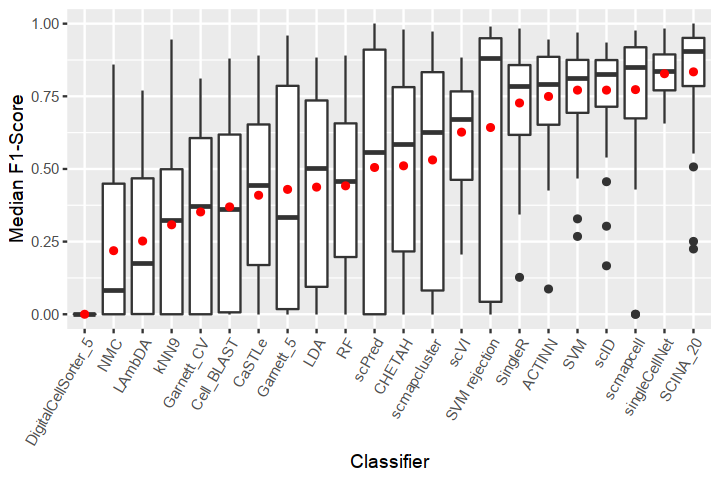

In [14]:
# Fig3 data from benchmarking paper
options(repr.plot.width = 6, repr.plot.height = 4)
ggplot(results, aes(x = reorder(Classifier, Value, FUN = mean), y = Value)) + 
  geom_boxplot() +
  xlab('Classifier') +
  ylab('Median F1-Score') +
  stat_summary(fun="mean", geom="point", colour = "red") +
  theme(axis.text.x = element_text(angle = 60, hjust = 1))

# Variable genes

## Configure and submit pbmc analyses

In [6]:
script = 'run_analysis-vargenes.R'
save = 'results/results_vargenes'

In [7]:
# Build the strings but DO NOT SUBMIT
lapply(1:2, function(x){
    if(x == 1) { # only send email for the first analysis (to avoid flooding inbox)
        bsub_symphony(script_use = script, 
                      analysis = analyses[x, 'analysis_name'],
                      rexp = add_prefix(analyses[x, 'train_dataset']), 
                      rlabels = add_prefix(analyses[x, 'train_labels']),
                      qexp = add_prefix(analyses[x, 'test_dataset']),
                      qlabels = add_prefix(analyses[x, 'test_labels']), 
                      save_use = save, 
                      email = TRUE, queue = 'short', submit = FALSE)
    } else {
        bsub_symphony(script_use = script, 
                      analysis = analyses[x, 'analysis_name'],
                      rexp = add_prefix(analyses[x, 'train_dataset']), 
                      rlabels = add_prefix(analyses[x, 'train_labels']),
                      qexp = add_prefix(analyses[x, 'test_dataset']),
                      qlabels = add_prefix(analyses[x, 'test_labels']), 
                      save_use = save, 
                      email = FALSE, queue = 'short', submit = FALSE)
    }
})

[[1]]
[1] "bsub -q short Rscript run_analysis-vargenes.R --analysis pbmcbench_1 --rexp /data/srlab2/jkang/symphony_reproducibility/PbmcBench/data/Smart-Seq2/partitions/train_SM2_exp.rds --rlab /data/srlab2/jkang/symphony_reproducibility/PbmcBench/data/Smart-Seq2/partitions/train_SM2_labels.rds --qexp /data/srlab2/jkang/symphony_reproducibility/PbmcBench/data/Smart-Seq2/partitions/test_10Xv2_exp.rds --qlab /data/srlab2/jkang/symphony_reproducibility/PbmcBench/data/Smart-Seq2/partitions/test_10Xv2_labels.rds -o results/results_vargenes"

[[2]]
[1] "LSB_JOB_REPORT_MAIL=N bsub -q short Rscript run_analysis-vargenes.R --analysis pbmcbench_2 --rexp /data/srlab2/jkang/symphony_reproducibility/PbmcBench/data/Smart-Seq2/partitions/train_SM2_exp.rds --rlab /data/srlab2/jkang/symphony_reproducibility/PbmcBench/data/Smart-Seq2/partitions/train_SM2_labels.rds --qexp /data/srlab2/jkang/symphony_reproducibility/PbmcBench/data/Smart-Seq2/partitions/test_10Xv3_exp.rds --qlab /data/srlab2/jkang/symphony_reproducibility/PbmcBench/data/Smart-Seq2/partitions/test_10Xv3_labels.rds -o results/results_vargenes"

In [8]:
# Build the strings AND SUBMIT
lapply(1:48, function(x){
    if(x == 1) { # only send email for the first analysis (to avoid flooding inbox)
        bsub_symphony(script_use = script, 
                      analysis = analyses[x, 'analysis_name'],
                      rexp = add_prefix(analyses[x, 'train_dataset']), 
                      rlabels = add_prefix(analyses[x, 'train_labels']),
                      qexp = add_prefix(analyses[x, 'test_dataset']),
                      qlabels = add_prefix(analyses[x, 'test_labels']), 
                      save_use = save, 
                      email = TRUE, queue = 'vshort', submit = TRUE)
    } else {
        bsub_symphony(script_use = script, 
                      analysis = analyses[x, 'analysis_name'],
                      rexp = add_prefix(analyses[x, 'train_dataset']), 
                      rlabels = add_prefix(analyses[x, 'train_labels']),
                      qexp = add_prefix(analyses[x, 'test_dataset']),
                      qlabels = add_prefix(analyses[x, 'test_labels']), 
                      save_use = save, 
                      email = FALSE, queue = 'vshort', submit = TRUE)
    }
})

[[1]]
[1] 0

[[2]]
[1] 0

[[3]]
[1] 0

[[4]]
[1] 0

[[5]]
[1] 0

[[6]]
[1] 0

[[7]]
[1] 0

[[8]]
[1] 0

[[9]]
[1] 0

[[10]]
[1] 0

[[11]]
[1] 0

[[12]]
[1] 0

[[13]]
[1] 0

[[14]]
[1] 0

[[15]]
[1] 0

[[16]]
[1] 0

[[17]]
[1] 0

[[18]]
[1] 0

[[19]]
[1] 0

[[20]]
[1] 0

[[21]]
[1] 0

[[22]]
[1] 0

[[23]]
[1] 0

[[24]]
[1] 0

[[25]]
[1] 0

[[26]]
[1] 0

[[27]]
[1] 0

[[28]]
[1] 0

[[29]]
[1] 0

[[30]]
[1] 0

[[31]]
[1] 0

[[32]]
[1] 0

[[33]]
[1] 0

[[34]]
[1] 0

[[35]]
[1] 0

[[36]]
[1] 0

[[37]]
[1] 0

[[38]]
[1] 0

[[39]]
[1] 0

[[40]]
[1] 0

[[41]]
[1] 0

[[42]]
[1] 0

[[43]]
[1] 0

[[44]]
[1] 0

[[45]]
[1] 0

[[46]]
[1] 0

[[47]]
[1] 0

[[48]]
[1] 0

## Analyze pbmc bench analysis results

In [20]:
# Initialize results
analysis_names = analyses$analysis_name
res_all = as.data.frame(cbind(as.character(analysis_names), Med_F1 = 0))
res_all$Med_F1 = as.numeric(as.character(res_all$Med_F1))
colnames(res_all) = c('analysis_name', 'Med_F1')

In [21]:
# Read in the results
for (a in analysis_names) {
    query = readRDS(paste('results/results_vargenes/', a, '_query.rds', sep = ''))
    knn_res = evaluate(query$meta_data$cell_type_orig, query$meta_data$cell_type_pred_knn)
    saveRDS(knn_res, paste('results/results_vargenes/', a, '_res_knn.rds', sep = ''))
    
    res = readRDS(paste('results/results_vargenes/', a, '_res_knn.rds', sep = ''))
    medf1 = res$MedF1
    res_all[res_all$analysis_name == a, 'Med_F1'] = medf1
}

In [22]:
# Add labels
res_labeled = merge(tech_labels, res_all, by = 'analysis_name')
head(res_labeled)

,analysis_name,train,test,Med_F1
,<chr>,<chr>,<chr>,<dbl>
1,pbmcbench_1,Smart-Seq2,10Xv2,0.8323472
2,pbmcbench_10,10Xv2,CEL-Seq,0.8156425
3,pbmcbench_11,10Xv2,Drop-Seq,0.8791594
4,pbmcbench_12,10Xv2,inDrop,0.8628763
5,pbmcbench_13,10Xv2,Seq-Well,0.8292683
6,pbmcbench_14,10Xv2,10Xv2,0.9591837


png 
  2

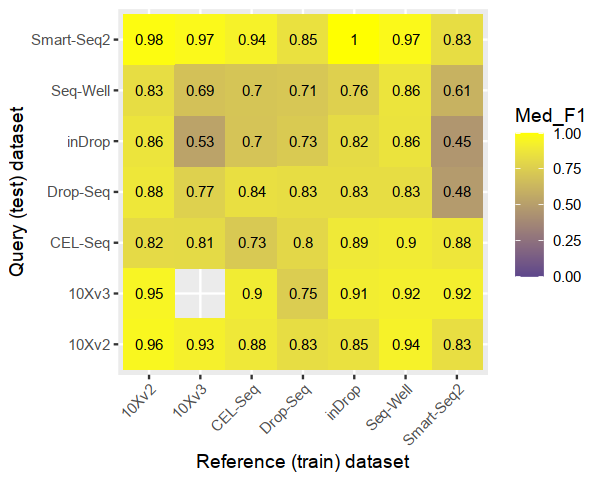

In [23]:
pdf('figures/train_test_F1_vargenes.pdf', width = 5, height = 4, useDingbats = FALSE)
options(repr.plot.width = 5, repr.plot.height = 4)

p = ggplot(res_labeled, aes(train, test)) +
    geom_tile(aes(fill = Med_F1)) + 
    geom_text(aes(label = round(Med_F1, 2)), size = 3) +
    scale_fill_gradient(low = "mediumpurple4", high = "yellow",  limits = c(0, 1)) +
    labs(y = 'Query (test) dataset', x = 'Reference (train) dataset') +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))
print(p)
dev.off()
p

In [24]:
median(res_labeled$Med_F1)
mean(res_labeled$Med_F1)

[1] 0.8359716

[1] 0.8226581

## With Symphony rejection option
Only include predictions with >0.6 confidence

In [50]:
# Initialize results
analysis_names = analyses$analysis_name
res_all = as.data.frame(cbind(as.character(analysis_names), Med_F1 = 0))
res_all$Med_F1 = as.numeric(as.character(res_all$Med_F1))
colnames(res_all) = c('analysis_name', 'Med_F1')

In [64]:
# Read in the results
total_num_cells = 0
num_cells_0.6 = 0
for (a in analysis_names) {
    query = readRDS(paste('results/results_vargenes/', a, '_query.rds', sep = ''))
    total_num_cells = total_num_cells + nrow(query$meta_data)
    
    query_meta_0.6 = query$meta_data[which(query$meta_data$cell_type_pred_knn_prob > 0.6), ]
    num_cells_0.6 = num_cells_0.6 + nrow(query_meta_0.6)
    
    knn_res = evaluate(query_meta_0.6$cell_type_orig, query_meta_0.6$cell_type_pred_knn)
    saveRDS(knn_res, paste('results/results_vargenes/', a, '_res_knn_0.6.rds', sep = ''))
    
    res = readRDS(paste('results/results_vargenes/', a, '_res_knn_0.6.rds', sep = ''))
    medf1 = res$MedF1
    res_all[res_all$analysis_name == a, 'Med_F1'] = medf1
}
total_num_cells 
num_cells_0.6

[1] 125644

[1] 108743

In [93]:
# Percent of cells unclassified across all experiments
100 * (125644 - 108743) / 125644

[1] 13.4515

In [65]:
# Add labels
res_labeled = merge(tech_labels, res_all, by = 'analysis_name')
head(res_labeled)

,analysis_name,train,test,Med_F1
,<chr>,<chr>,<chr>,<dbl>
1,pbmcbench_1,Smart-Seq2,10Xv2,0.8961542
2,pbmcbench_10,10Xv2,CEL-Seq,0.8741722
3,pbmcbench_11,10Xv2,Drop-Seq,0.9069767
4,pbmcbench_12,10Xv2,inDrop,0.8838437
5,pbmcbench_13,10Xv2,Seq-Well,0.8500000
6,pbmcbench_14,10Xv2,10Xv2,0.9666667


png 
  2

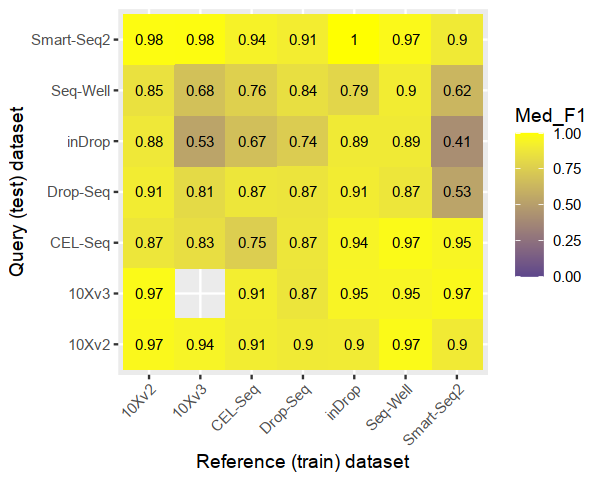

In [68]:
pdf('figures/train_test_F1_vargenes_0.6.pdf', width = 5, height = 4, useDingbats = FALSE)
options(repr.plot.width = 5, repr.plot.height = 4)

p = ggplot(res_labeled, aes(train, test)) +
    geom_tile(aes(fill = Med_F1)) + 
    geom_text(aes(label = round(Med_F1, 2)), size = 3) +
    scale_fill_gradient(low = "mediumpurple4", high = "yellow",  limits = c(0, 1)) +
    labs(y = 'Query (test) dataset', x = 'Reference (train) dataset') +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))
print(p)
dev.off()
p

In [69]:
median(res_labeled$Med_F1)
mean(res_labeled$Med_F1)

[1] 0.8953402

[1] 0.8591176

# Top 20 DEGs

## Configure and submit analyses

In [17]:
script = 'run_analysis-add-markers-20.R'
save = '/data/srlab2/jkang/symphony_reproducibility/PbmcBench/results/results_marker-genes-20'

In [18]:
# Build the strings but DO NOT SUBMIT
lapply(1:2, function(x){
    if(x == 1) { # only send email for the first analysis (to avoid flooding inbox)
        bsub_symphony(script_use = script, 
                      analysis = analyses[x, 'analysis_name'],
                      rexp = add_prefix(analyses[x, 'train_dataset']), 
                      rlabels = add_prefix(analyses[x, 'train_labels']),
                      qexp = add_prefix(analyses[x, 'test_dataset']),
                      qlabels = add_prefix(analyses[x, 'test_labels']), 
                      save_use = save, 
                      email = TRUE, queue = 'short', submit = FALSE)
    } else {
        bsub_symphony(script_use = script, 
                      analysis = analyses[x, 'analysis_name'],
                      rexp = add_prefix(analyses[x, 'train_dataset']), 
                      rlabels = add_prefix(analyses[x, 'train_labels']),
                      qexp = add_prefix(analyses[x, 'test_dataset']),
                      qlabels = add_prefix(analyses[x, 'test_labels']), 
                      save_use = save, 
                      email = FALSE, queue = 'short', submit = FALSE)
    }
})

[[1]]
[1] "bsub -q short Rscript run_analysis-add-markers-20.R --analysis pbmcbench_1 --rexp /data/srlab2/jkang/symphony_reproducibility/PbmcBench/data/Smart-Seq2/partitions/train_SM2_exp.rds --rlab /data/srlab2/jkang/symphony_reproducibility/PbmcBench/data/Smart-Seq2/partitions/train_SM2_labels.rds --qexp /data/srlab2/jkang/symphony_reproducibility/PbmcBench/data/Smart-Seq2/partitions/test_10Xv2_exp.rds --qlab /data/srlab2/jkang/symphony_reproducibility/PbmcBench/data/Smart-Seq2/partitions/test_10Xv2_labels.rds -o /data/srlab2/jkang/symphony_reproducibility/PbmcBench/results/results_marker-genes-20"

[[2]]
[1] "LSB_JOB_REPORT_MAIL=N bsub -q short Rscript run_analysis-add-markers-20.R --analysis pbmcbench_2 --rexp /data/srlab2/jkang/symphony_reproducibility/PbmcBench/data/Smart-Seq2/partitions/train_SM2_exp.rds --rlab /data/srlab2/jkang/symphony_reproducibility/PbmcBench/data/Smart-Seq2/partitions/train_SM2_labels.rds --qexp /data/srlab2/jkang/symphony_reproducibility/PbmcBench/data/Smart-Seq2/partitions/test_10Xv3_exp.rds --qlab /data/srlab2/jkang/symphony_reproducibility/PbmcBench/data/Smart-Seq2/partitions/test_10Xv3_labels.rds -o /data/srlab2/jkang/symphony_reproducibility/PbmcBench/results/results_marker-genes-20"

In [19]:
# Build the strings AND SUBMIT
lapply(1:48, function(x){
    if(x == 1) { # only send email for the first analysis (to avoid flooding inbox)
        bsub_symphony(script_use = script, 
                      analysis = analyses[x, 'analysis_name'],
                      rexp = add_prefix(analyses[x, 'train_dataset']), 
                      rlabels = add_prefix(analyses[x, 'train_labels']),
                      qexp = add_prefix(analyses[x, 'test_dataset']),
                      qlabels = add_prefix(analyses[x, 'test_labels']), 
                      save_use = save, 
                      email = TRUE, queue = 'vshort', submit = TRUE)
    } else {
        bsub_symphony(script_use = script, 
                      analysis = analyses[x, 'analysis_name'],
                      rexp = add_prefix(analyses[x, 'train_dataset']), 
                      rlabels = add_prefix(analyses[x, 'train_labels']),
                      qexp = add_prefix(analyses[x, 'test_dataset']),
                      qlabels = add_prefix(analyses[x, 'test_labels']), 
                      save_use = save, 
                      email = FALSE, queue = 'vshort', submit = TRUE)
    }
})

[[1]]
[1] 0

[[2]]
[1] 0

[[3]]
[1] 0

[[4]]
[1] 0

[[5]]
[1] 0

[[6]]
[1] 0

[[7]]
[1] 0

[[8]]
[1] 0

[[9]]
[1] 0

[[10]]
[1] 0

[[11]]
[1] 0

[[12]]
[1] 0

[[13]]
[1] 0

[[14]]
[1] 0

[[15]]
[1] 0

[[16]]
[1] 0

[[17]]
[1] 0

[[18]]
[1] 0

[[19]]
[1] 0

[[20]]
[1] 0

[[21]]
[1] 0

[[22]]
[1] 0

[[23]]
[1] 0

[[24]]
[1] 0

[[25]]
[1] 0

[[26]]
[1] 0

[[27]]
[1] 0

[[28]]
[1] 0

[[29]]
[1] 0

[[30]]
[1] 0

[[31]]
[1] 0

[[32]]
[1] 0

[[33]]
[1] 0

[[34]]
[1] 0

[[35]]
[1] 0

[[36]]
[1] 0

[[37]]
[1] 0

[[38]]
[1] 0

[[39]]
[1] 0

[[40]]
[1] 0

[[41]]
[1] 0

[[42]]
[1] 0

[[43]]
[1] 0

[[44]]
[1] 0

[[45]]
[1] 0

[[46]]
[1] 0

[[47]]
[1] 0

[[48]]
[1] 0

## Analyze pbmc bench analysis results

In [25]:
# Initialize results
res_all = as.data.frame(cbind(as.character(analysis_names), Med_F1 = 0))
res_all$Med_F1 = as.numeric(as.character(res_all$Med_F1))

colnames(res_all) = c('analysis_name', 'Med_F1')

In [26]:
# Read in the results
for (a in analysis_names) {
    res = readRDS(paste('results/results_marker-genes-20/', a, '_res_knn.rds', sep = ''))
    medf1 = res$MedF1
    res_all[res_all$analysis_name == a, 'Med_F1'] = medf1
}

In [27]:
# Add labels
res_labeled = merge(tech_labels, res_all, by = 'analysis_name')
head(res_labeled)

,analysis_name,train,test,Med_F1
,<chr>,<chr>,<chr>,<dbl>
1,pbmcbench_1,Smart-Seq2,10Xv2,0.9350591
2,pbmcbench_10,10Xv2,CEL-Seq,0.7567568
3,pbmcbench_11,10Xv2,Drop-Seq,0.8654078
4,pbmcbench_12,10Xv2,inDrop,0.7472952
5,pbmcbench_13,10Xv2,Seq-Well,0.8095238
6,pbmcbench_14,10Xv2,10Xv2,0.9253731


png 
  2

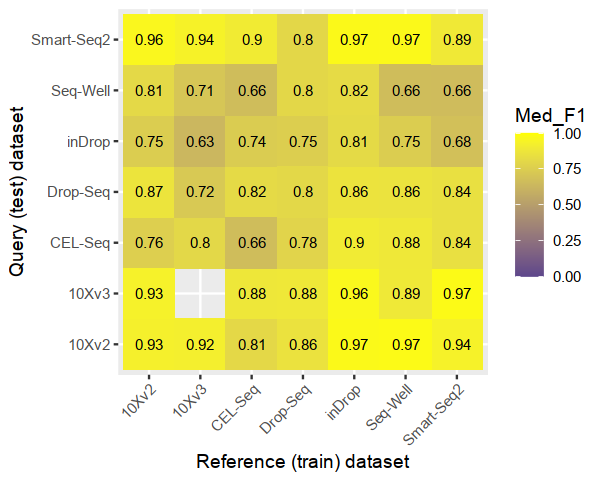

In [40]:
pdf('figures/train_test_F1_DEGs_knn.pdf', width = 5, height = 4, useDingbats = FALSE)
options(repr.plot.width = 5, repr.plot.height = 4)

p = ggplot(res_labeled, aes(train, test)) +
    geom_tile(aes(fill = Med_F1)) + 
    geom_text(aes(label = round(Med_F1, 2)), size = 3) +
    scale_fill_gradient(low = "mediumpurple4", high = "yellow",  limits = c(0, 1)) +
    labs(y = 'Query (test) dataset', x = 'Reference (train) dataset') +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))
print(p)
dev.off()
p

In [41]:
median(res_labeled$Med_F1)
mean(res_labeled$Med_F1)

[1] 0.8417739

[1] 0.8325342

## With Symphony rejection option
Only include predictions with >0.6 confidence

In [70]:
# Initialize results
analysis_names = analyses$analysis_name
res_all = as.data.frame(cbind(as.character(analysis_names), Med_F1 = 0))
res_all$Med_F1 = as.numeric(as.character(res_all$Med_F1))
colnames(res_all) = c('analysis_name', 'Med_F1')

In [71]:
# Read in the results
total_num_cells = 0
num_cells_0.6 = 0
for (a in analysis_names) {
    query = readRDS(paste('results/results_marker-genes-20/', a, '_query.rds', sep = ''))
    total_num_cells = total_num_cells + nrow(query$meta_data)
    
    query_meta_0.6 = query$meta_data[which(query$meta_data$cell_type_pred_knn_prob > 0.6), ]
    num_cells_0.6 = num_cells_0.6 + nrow(query_meta_0.6)
    
    knn_res = evaluate(query_meta_0.6$cell_type_orig, query_meta_0.6$cell_type_pred_knn)
    saveRDS(knn_res, paste('results/results_marker-genes-20/', a, '_res_knn_0.6.rds', sep = ''))
    
    res = readRDS(paste('results/results_marker-genes-20/', a, '_res_knn_0.6.rds', sep = ''))
    medf1 = res$MedF1
    res_all[res_all$analysis_name == a, 'Med_F1'] = medf1
}
total_num_cells 
num_cells_0.6

[1] 125644

[1] 108122

In [94]:
# Percent of cells unclassified across all experiments
100 * (125644 - 108122) / 125644

[1] 13.94575

In [72]:
# Add labels
res_labeled = merge(tech_labels, res_all, by = 'analysis_name')
head(res_labeled)

,analysis_name,train,test,Med_F1
,<chr>,<chr>,<chr>,<dbl>
1,pbmcbench_1,Smart-Seq2,10Xv2,0.9505526
2,pbmcbench_10,10Xv2,CEL-Seq,0.8108108
3,pbmcbench_11,10Xv2,Drop-Seq,0.9104205
4,pbmcbench_12,10Xv2,inDrop,0.7820408
5,pbmcbench_13,10Xv2,Seq-Well,0.8533333
6,pbmcbench_14,10Xv2,10Xv2,0.9583333


png 
  2

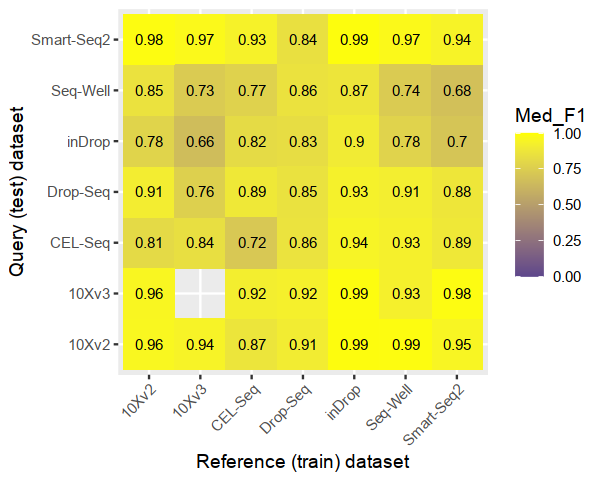

In [73]:
pdf('figures/train_test_F1_DEGs_knn_0.6.pdf', width = 5, height = 4, useDingbats = FALSE)
options(repr.plot.width = 5, repr.plot.height = 4)

p = ggplot(res_labeled, aes(train, test)) +
    geom_tile(aes(fill = Med_F1)) + 
    geom_text(aes(label = round(Med_F1, 2)), size = 3) +
    scale_fill_gradient(low = "mediumpurple4", high = "yellow",  limits = c(0, 1)) +
    labs(y = 'Query (test) dataset', x = 'Reference (train) dataset') +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))
print(p)
dev.off()
p

In [74]:
median(res_labeled$Med_F1)
mean(res_labeled$Med_F1)

[1] 0.8915146

[1] 0.8749447

# Add additional predictive models
It is important to note that Symphony is compatible with other downstream classifiers beyond k-NN. Here, we demonstrate using SVM and GLM (multinomial logistic regression with ridge).

In [36]:
# Function that builds the bsub command as a string
bsub_symphony = function(script_use, queue = 'short', email = FALSE, analysis = NULL, rexp = NULL, rlabels = NULL,
                          qexp = NULL, qlabels = NULL, save_use, submit = FALSE){
    str = paste('bsub -q', 
                queue, 
                'Rscript', script_use, 
                '--analysis', analysis, 
                '-o', save_use)
    if(email == FALSE){
        str = paste('LSB_JOB_REPORT_MAIL=N', str) #Add flag to avoid spamming yourself
    } 
    if(submit == FALSE){ # just print out the command
        str
    } else { # actually submit via lsf
        system(str)
    }
}

In [37]:
script = 'run_analysis_svm_glmnet.R'
save = 'results/results_svm_glmnet'

In [38]:
# Build the strings but DO NOT SUBMIT
lapply(1:2, function(x){
    if(x == 1) { # only send email for the first analysis (to avoid flooding inbox)
        bsub_symphony(script_use = script, 
                      analysis = analyses[x, 'analysis_name'],
                      save_use = save, 
                      email = TRUE, queue = 'short', submit = FALSE)
    } else {
        bsub_symphony(script_use = script, 
                      analysis = analyses[x, 'analysis_name'],
                      save_use = save, 
                      email = FALSE, queue = 'short', submit = FALSE)
    }
})

[[1]]
[1] "bsub -q short Rscript run_analysis_svm_glmnet.R --analysis pbmcbench_1 -o results/results_svm_glmnet"

[[2]]
[1] "LSB_JOB_REPORT_MAIL=N bsub -q short Rscript run_analysis_svm_glmnet.R --analysis pbmcbench_2 -o results/results_svm_glmnet"

In [39]:
# Build the strings AND SUBMIT
lapply(1:48, function(x){
    if(x == 1) { # only send email for the first analysis (to avoid flooding inbox)
        bsub_symphony(script_use = script, 
                      analysis = analyses[x, 'analysis_name'],
                      save_use = save, 
                      email = TRUE, queue = 'vshort', submit = TRUE)
    } else {
        bsub_symphony(script_use = script, 
                      analysis = analyses[x, 'analysis_name'],
                      save_use = save, 
                      email = FALSE, queue = 'vshort', submit = TRUE)
    }
})

[[1]]
[1] 0

[[2]]
[1] 0

[[3]]
[1] 0

[[4]]
[1] 0

[[5]]
[1] 0

[[6]]
[1] 0

[[7]]
[1] 0

[[8]]
[1] 0

[[9]]
[1] 0

[[10]]
[1] 0

[[11]]
[1] 0

[[12]]
[1] 0

[[13]]
[1] 0

[[14]]
[1] 0

[[15]]
[1] 0

[[16]]
[1] 0

[[17]]
[1] 0

[[18]]
[1] 0

[[19]]
[1] 0

[[20]]
[1] 0

[[21]]
[1] 0

[[22]]
[1] 0

[[23]]
[1] 0

[[24]]
[1] 0

[[25]]
[1] 0

[[26]]
[1] 0

[[27]]
[1] 0

[[28]]
[1] 0

[[29]]
[1] 0

[[30]]
[1] 0

[[31]]
[1] 0

[[32]]
[1] 0

[[33]]
[1] 0

[[34]]
[1] 0

[[35]]
[1] 0

[[36]]
[1] 0

[[37]]
[1] 0

[[38]]
[1] 0

[[39]]
[1] 0

[[40]]
[1] 0

[[41]]
[1] 0

[[42]]
[1] 0

[[43]]
[1] 0

[[44]]
[1] 0

[[45]]
[1] 0

[[46]]
[1] 0

[[47]]
[1] 0

[[48]]
[1] 0

# How does Symphony compare to other tools?

In [88]:
res_symphony = NULL

# Read in the results
for (a in analysis_names) {
    Symphony_vargenes_knn = readRDS(paste('results/results_vargenes/', a, '_res_knn.rds', sep = ''))$MedF1
    Symphony_vargenes_knn_rej = readRDS(paste('results/results_vargenes/', a, '_res_knn_0.6.rds', sep = ''))$MedF1
    Symphony_vargenes_glmnet = readRDS(paste('results/results_svm_glmnet/', a, '_res_vargenes_glmnet.rds', sep = ''))$MedF1
    Symphony_vargenes_svm = readRDS(paste('results/results_svm_glmnet/', a, '_res_vargenes_svm.rds', sep = ''))$MedF1
    
    Symphony_DEGs_knn = readRDS(paste('results/results_marker-genes-20/', a, '_res_knn.rds', sep = ''))$MedF1
    Symphony_DEGs_knn_rej = readRDS(paste('results/results_marker-genes-20/', a, '_res_knn_0.6.rds', sep = ''))$MedF1
    Symphony_DEGs_glmnet = readRDS(paste('results/results_svm_glmnet/', a, '_res_degs_glmnet.rds', sep = ''))$MedF1
    Symphony_DEGs_svm = readRDS(paste('results/results_svm_glmnet/', a, '_res_degs_svm.rds', sep = ''))$MedF1
    
    
    
    Classifier = c('Symphony_vargenes_kNN', 'Symphony_vargenes_kNN_predconf>0.6', 
                   'Symphony_vargenes_GLM', 'Symphony_vargenes_SVM',
                    'Symphony_DEGs_kNN', 'Symphony_DEGs_kNN_predconf>0.6',
                    'Symphony_DEGs_GLM', 'Symphony_DEGs_SVM')
    
    res_symphony_fold = cbind(Classifier,
                              rbind(Symphony_vargenes_knn, Symphony_vargenes_knn_rej, 
                                    Symphony_vargenes_glmnet, Symphony_vargenes_svm, 
                                    Symphony_DEGs_knn, Symphony_DEGs_knn_rej, 
                                    Symphony_DEGs_glmnet, Symphony_DEGs_svm))
    res_symphony = rbind(res_symphony, res_symphony_fold)
}

res_symphony = res_symphony %>% as.data.frame()
colnames(res_symphony) = c('Classifier', 'Value')
rownames(res_symphony) = NULL

res_comparison = rbind(results[,4:5], res_symphony)
res_comparison$Value = as.numeric(res_comparison$Value)
res_comparison$highlight = FALSE
res_comparison$highlight[which(grepl('Symphony', res_comparison$Classifier))] = TRUE

png 
  2

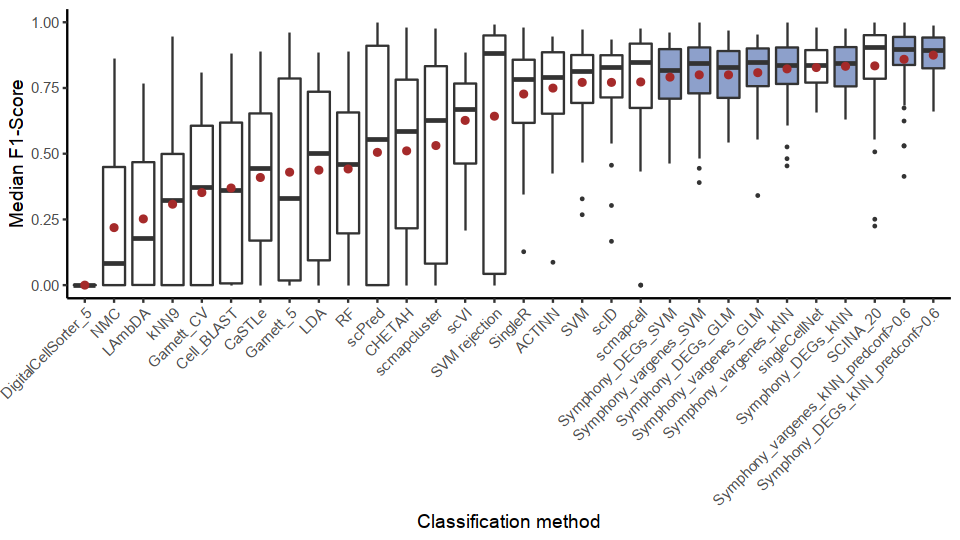

In [95]:
pdf('figures/comparison_to_other_tools_with_rejection.pdf', width = 8, height = 4.5, useDingbats = FALSE)
options(repr.plot.width = 8, repr.plot.height = 4.5)
p = ggplot(res_comparison, aes(x = reorder(Classifier, Value, FUN = mean), y=Value, fill = highlight)) + 
  geom_boxplot(outlier.size = 0.3) +
  theme_classic() +
  xlab('Classification method') +
  ylab('Median F1-Score') +
  theme(axis.text.x = element_text(angle = 45, hjust = 1), legend.position = 'none') + 
  stat_summary(fun="mean", geom="point", colour = "brown") +
  scale_fill_manual(values=c('white', '#8DA0CB'))

print(p)
dev.off()
p

In [90]:
test = res_comparison[res_comparison$Classifier %in% c('scmapcell', 
                                                'Symphony_vargenes_kNN', 'Symphony_vargenes_kNN_predconf>0.6', 
                                                'Symphony_vargenes_GLM', 'Symphony_vargenes_SVM', 
                                                'Symphony_DEGs_kNN', 'Symphony_DEGs_kNN_predconf>0.6',
                                                'Symphony_DEGs_GLM', 'Symphony_DEGs_SVM',
                                                'singleCellNet', 'SCINA_20'),]

In [91]:
aggregate(test[, 'Value'], list(test$Classifier), mean)

Group.1,x
<chr>,<dbl>
SCINA_20,0.8341525
scmapcell,0.7730334
singleCellNet,0.8277170
Symphony_DEGs_GLM,0.7999366
Symphony_DEGs_kNN,0.8325342
Symphony_DEGs_kNN_predconf>0.6,0.8749447
Symphony_DEGs_SVM,0.7912828
Symphony_vargenes_GLM,0.8082842
Symphony_vargenes_kNN,0.8226581


# All done!

In [49]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server release 6.5 (Santiago)

Matrix products: default
BLAS/LAPACK: /PHShome/jbk37/anaconda3/envs/seurat4/lib/libopenblasp-r0.3.15.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] ggpubr_0.4.0            ggrastr_0.2.3           reshape2_1.4.4         
 [4] RANN_2.6.1              class_7.3-19            singlecellmethods_0.1.0
 [7] plyr_1.8.6              Matrix_1.3-3            ggthemes_4.2.4         
[10] patchwork_1.1.1         matrix